<h3>Wishbone for mass cytometry</h3>

<h4>Table of contents</h4>
<br/>
<a href='#intro'>Introduction</a>
<br/>
<a href='#data'>Loading data</a>
<br/>
<a href='#pre'>Data preprocessing</a>
<br/>
<a href='#wishbone'>Running Wishbone</a>
<br/>
<a href='#wishbone2'>Visualizing Wishbone results</a>
<br/>
<a href='#pheno'>Clustering of cells</a>
<br/>
<a href='#gating'>Gating for start cells</a>

<a id="intro"></a><h3> Introduction </h3>

Wishbone is an algorithm to identify bifurcating developmental trajectories from single cell data. Wishbone can applied to both single cell RNA-seq and mass cytometry datasets. This notebook details the usage of Wishbone for mass cytometry data.

<a id="data"></a><h3> Loading data </h3>

Wishbone can read mass cytometry data from a fcs file. The following code snipped imports the `wishbone` package along with other plotting related imports

In [1]:
import wishbone

# Plotting and miscellaneous imports
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


A sample mass cytometry fcs file is installed at `~/.wishbone/data/sample_masscyt.fcs`. This is a sample of cells from replicate of the mouse thymus data generated for the Wishbone manuscript. Thus the data is already cleaned and `arcsinh` transformed. The data can be loaded using the `wishbone.wb.SCData.from_fcs` function. 

In [2]:
# Load sample data
scdata = wishbone.wb.SCData.from_fcs(os.path.expanduser('~/.wishbone/data/sample_masscyt.fcs'), 
            cofactor=None)

This will create an object of the type `wishbone.wb.SCData` which is the base class for the analysis. The `cofactor` parameter is used for `arcsinh` transformation. Since the data is already transformed, `cofactor` is set to `None`. Typically, this parameter will be set to default (`5`) for untransformed data.

A summary of the `scdata` object is shown below

In [3]:
scdata

SCData: 25000 cells x 13 genes

cluster_assignments=None
data_type=True
diffusion_eigenvalues=None
diffusion_eigenvectors=None
diffusion_map_correlations=None
library_sizes=None
metadata=True
normalized=True
pca=None
tsne=None

This shows that the data matrix contains `25000` cells and `13` markers along with the different properties of the `wishbone.wb.SCData` class.

<a id='pre'></a><h3>Data preprocessing</h3>

<h4> tSNE visualization </h4>

Wishbone uses tSNE for visualization and tSNE can be run using the `run_tsne` function. Unlike single cell RNA-seq data, `tSNE` is run directly on the transformed data for mass cytometry. 

In [4]:
scdata.run_tsne()

If running in notebook, please look at the command line window for tSNE progress log


tSNE results can be visualized by the `plot_tsne` function. 

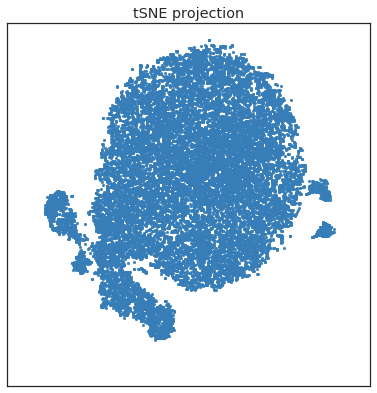

In [5]:
fig, ax = scdata.plot_tsne()

Gene expression can be visualized on tSNE maps using the `plot_gene_expression` function. The `genes` parameter is an string iterable of genes, which are a subset of the expression of column names. The below function plots the expression of DN genes `CD44` and `CD25`, SP genes `CD4` and `CD8`

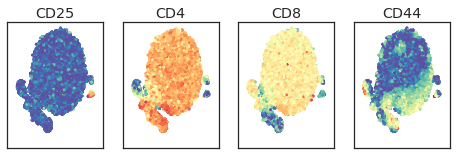

In [6]:
fig, ax = scdata.plot_gene_expression(['CD44', 'CD25', 'CD4', 'CD8'])

The below example shows how the user can compare expression of the desired markers. The plot comparing expression of `CD8` and `CD4` is shown below

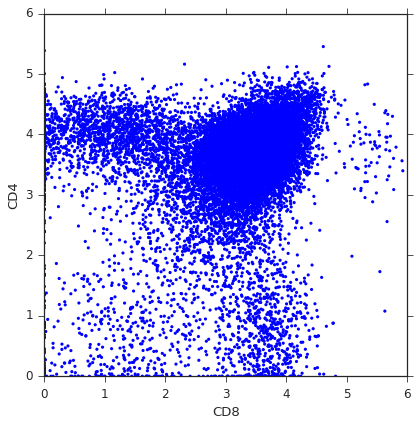

In [7]:
fig, ax = wishbone.wb.get_fig()
plt.scatter(scdata.data['CD8'], scdata.data['CD4'], 
    s=10, edgecolors='none')
plt.xlim([0, 6])
plt.ylim([0, 6])
plt.xlabel('CD8')
plt.ylabel('CD4')

<h4> Diffusion maps </h4>

Wishbone uses diffusion maps, a non-linear dimensionality reduction technique to denoise the data and capture the major axes of variation. Diffusion maps can be determined by using the `run_diffusion_map` function and the diffusion components visualized on tSNE maps using `plot_diffusion_components`.

In [8]:
# Run diffusion maps
scdata.run_diffusion_map()

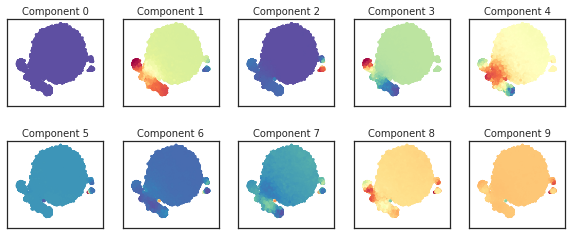

In [9]:
fig, ax = scdata.plot_diffusion_components()

Note the component 0 is the trivial component with eigen value 1 and does not encode any information of the data

From the above plots, the first three non-trivial components (Components 1, 2, 3), capture the differences between cell types. This difference in information encoded can be clearly seen by the eigen values associated with these components. Simiar to PCA, the eigen values encode the amount of variance explained in the data and can be visualized usign the `plot_diffusion_eigen_vectors` function.

(<matplotlib.figure.Figure at 0x10ef60128>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10ef53588>)

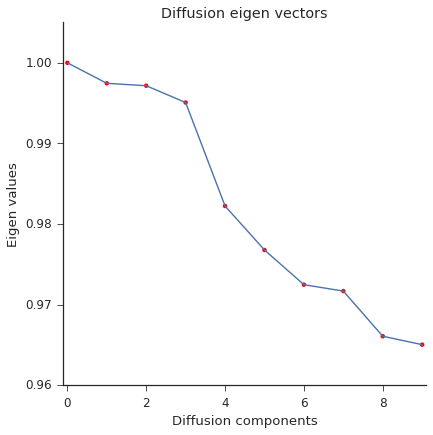

In [10]:
scdata.plot_diffusion_eigen_vectors()

A clear drop-off in eigen value can be seen after component 3. Thus Wishbone will be run using components 1, 2 and 3

<h4> Saving SCData object </h4>

The `SCData` object can be saved to a pickle file and loaded using the `save` and `load` functions.
<code>
scdata.save('mouse_thymus_scdata.p')
scdata = wishbone.wb.SCdata.load('mouse_thymus_scdata.p')
</code>

<a id="wishbone"></a><h3> Running Wishbone </h3>

`wishbone.wb.Wishbone` is the class for running Wishbone. After initialization, Wishbone can be run by specifying the start cell, components to use and number of waypoints to be used. The start cell for this dataset is one of the DN cells based on expression of CD4 and CD8. A sample list of waypoints is also provided as part of the data. The parameter can also be an integer representing the number of waypoints to be sampled from the data.

In [11]:
# Start cell
start_cell = scdata.data.index[(scdata.data['CD4'] < 1) & (scdata.data['CD8'] < 1)][0]
# Waypoints
waypoints = pd.DataFrame.from_csv(os.path.expanduser('~/.wishbone/data/masscyt_waypoints.csv')).iloc[:, 0]
waypoints = list(waypoints)

In [12]:
# Wishbone class
wb = wishbone.wb.Wishbone(scdata)
wb.run_wishbone(start_cell, components_list=[1, 2, 3], num_waypoints=waypoints)

Building lNN graph...
lNN computed in : 0.14 seconds
Determining waypoints if not specified...
Determining shortest path distances and perspectives....
..........................................................................................................................................................................................................................................................
Time for determining distances and perspectives: 335.36 seconds
Determining branch point and branch associations...
Running iterations...
Iteration: 2
Correlation with previous iteration:  1.0000
1 realignment iterations


`Wishbone` objects contain the `SCData` object along with the identified trajectory, branch associations and waypoints

In [13]:
wb

Wishbone object: 25000 cells x 13 genes

branch=True
branch_colors=True
trajectory=True
waypoints=True

<a id="wishbone2"></a><h3> Visualizing Wishbone results </h3>

Wishbone trajectory and branch results can be visualized on tSNE maps using the `plot_wishbone_on_tsne` function

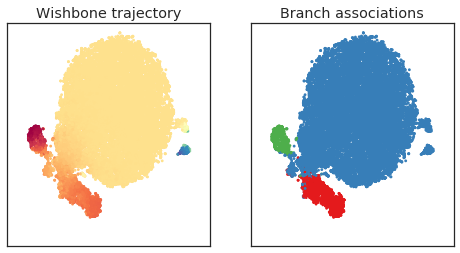

In [14]:
fig, ax = wb.plot_wishbone_on_tsne()

Gene expression trends along the Wishbone trajectory can be visualized using the `plot_marker_trajectory` function. This function also returns the smoothed trends along with the matplotlib fig, ax handler objects.

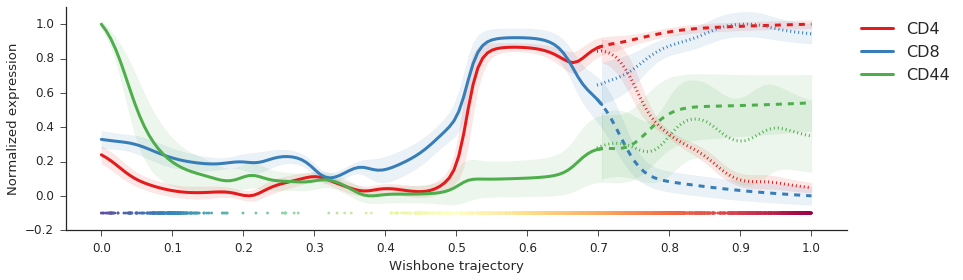

In [15]:
vals, fig, ax = wb.plot_marker_trajectory(['CD4', 'CD8', 'CD44'], 
                    smoothing_factor=1.5, show_variance=True);

The marker trends can be visualized as heatmaps in a given trajectory range using the following functions

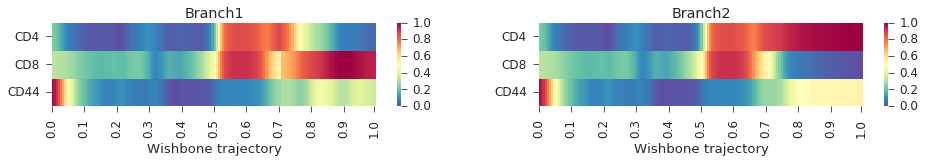

In [16]:
fig, ax = wb.plot_marker_heatmap(vals)

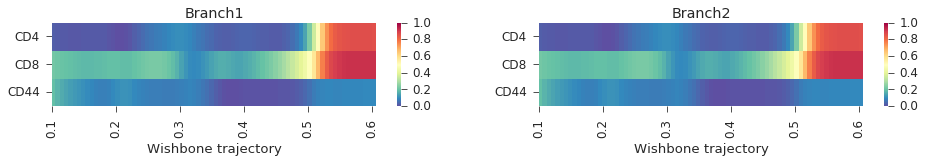

In [17]:
fig, ax = wb.plot_marker_heatmap(vals, trajectory_range=[0.1, 0.6])

The change in marker trends along the trajectory or derivatives can be visualized using these functions

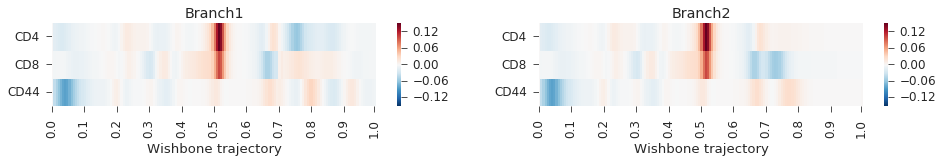

In [18]:
fig, ax = wb.plot_derivatives(vals)

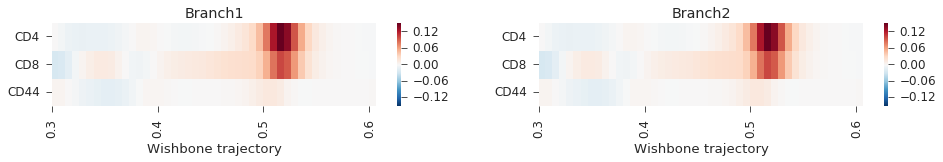

In [19]:
fig, ax = wb.plot_derivatives(vals, trajectory_range=[0.3, 0.6])

Similar to `SCData` objects, `Wishbone` objects can also be saved and loaded using `save` and `load` functions.

<a id='pheno'></a><h3>Clustering of cells </h3>

Clustering of cells to identify phenopytically distinct populations can be performed using the `run_phenograph` function. This function uses <a href="">Phenograph</a> to cluster the cells. Phenograph was used in the Wishbone manuscript to filter out stromal cells and regulatory T cells from the mouse thymus

In [20]:
scdata.run_phenograph()

Finding 30 nearest neighbors using minkowski metric and 'kd_tree' algorithm
Neighbors computed in 3.436298131942749 seconds
Jaccard graph constructed in 2.682620048522949 seconds
Wrote graph to binary file in 1.75370192527771 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.713473
After 2 runs, maximum modularity is Q = 0.71652
After 6 runs, maximum modularity is Q = 0.718894
After 10 runs, maximum modularity is Q = 0.722684
Louvain completed 30 runs in 33.40153908729553 seconds
PhenoGraph complete in 41.36935901641846 seconds


The results of Phenograph can be visualized on the tSNE maps using the function `plot_phenograph_clusters` and the mean expression of all markers in each cluster can be visualized as a heatmap using the function `summarize_phenograph_clusters`

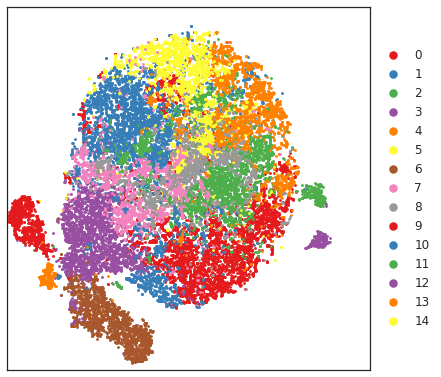

In [21]:
fig, ax = scdata.plot_phenograph_clusters()

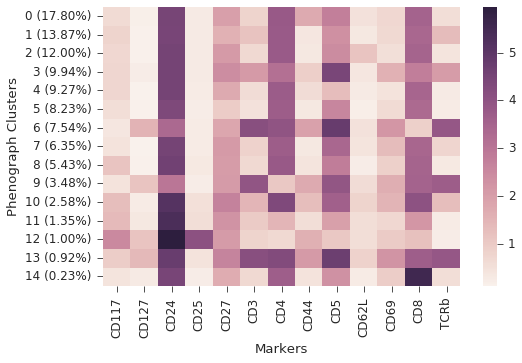

In [22]:
fig, ax = scdata.summarize_phenograph_clusters()

Finally, a new `SCData` with cells belonging to a subset of clusters can be generated using the `select_clusters` function

In [23]:
new_scd = scdata.select_clusters([0, 1, 2, 3])
new_scd

SCData: 13403 cells x 13 genes

cluster_assignments=None
data_type=True
diffusion_eigenvalues=None
diffusion_eigenvectors=None
diffusion_map_correlations=None
library_sizes=None
metadata=True
normalized=True
pca=None
tsne=None

<a id='gating'></a><h3>Gating for start cells </h3>

The python implementation of Wishbone does not yet support the specification of a get for start cells. This section provides information about how to choose a cell from a desired section of the tSNE plot

As a first step, change the plotting defaults to show the axes on tSNE maps and use alternative `matplotlib` settings to have the ability to zoom in and out


In [30]:
%matplotlib notebook
sns.set_style('whitegrid')

Plot tSNE results on a scatter plot

<IPython.core.display.Javascript object>


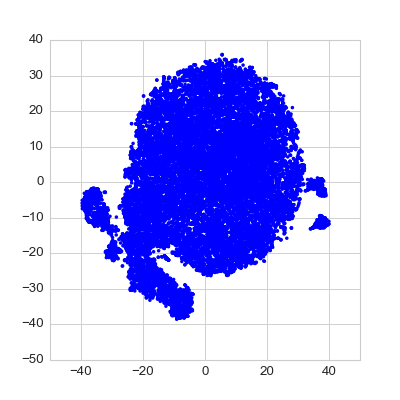

In [31]:
plt.figure(figsize=[5, 5])
plt.scatter(scdata.tsne['x'], scdata.tsne['y'], s=10, edgecolors='none')

The gate can be set using the `matplotlib.path` functions. Make sure to choose a closed path by specifying the x-y co ordinates of the desired gate.

In [26]:
# The gate should be specified as x1, y1, x2, y2,....xn, yn
gate = matplotlib.path.Path(np.reshape([30, -20, 40, -20, 40, -10, 30, -10, 30, -20], [5, 2]))

The cells within the `gate` can be identified and plotted using the following code snippet

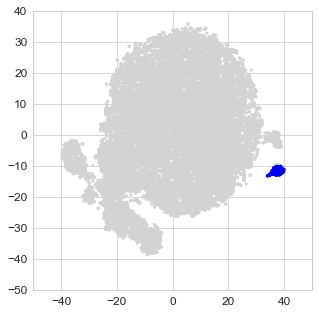

In [27]:
gated_cells = scdata.tsne.index[gate.contains_points(scdata.tsne)]

# Plot the gated cells
%matplotlib inline
plt.figure(figsize=[5, 5])
plt.scatter(scdata.tsne['x'], scdata.tsne['y'], s=10, edgecolors='none', color='lightgrey')
plt.scatter(scdata.tsne.ix[gated_cells, 'x'], scdata.tsne.ix[gated_cells, 'y'], s=10, edgecolors='none')

Randomly select one of the cells from the gated cells as the start cell

In [28]:
start_cell = random.sample(list(gated_cells), 1)[0]
start_cell

1256